C:\Users\Kyle\AppData\Local\Temp\ipykernel_24936\1531943585.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0     -0.080206
1      1.379431
4      0.360584
6     -1.939639
7      0.615216
         ...   
992    0.631965
995   -0.677969
996    0.580690
998    0.598129
999    0.405107
Name: online_visits, Length: 418, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cust_df_bc.iloc[:,col_idx] = \
C:\Users\Kyle\AppData\Local\Temp\ipykernel_24936\1531943585.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0     -0.657096
1      1.440249
4      0.430969
6     -1.438329
7      0.570239
         ...   
992    0.790722
995   -0.235211
996    0.922039
998    0.262178
999    0.350972
Name: online_trans, Length: 418, dtype: float64' has dtype incompatible with int64, please explicitly cast t

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,407.0,3.303249,0.0,NaN,NaN,NaN
1,416.0,3.330059,-9.0,-0.02681,0.372126,NaN


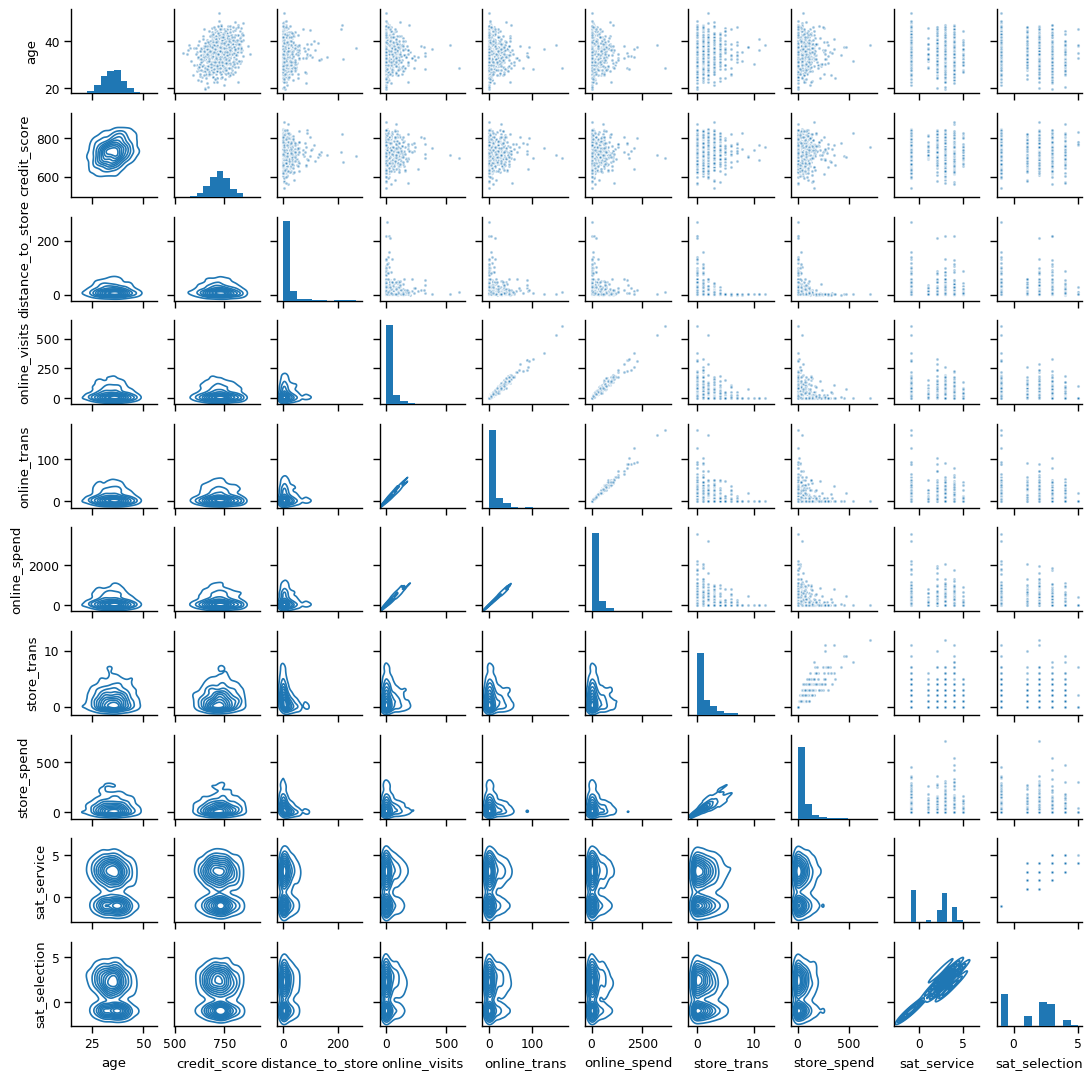

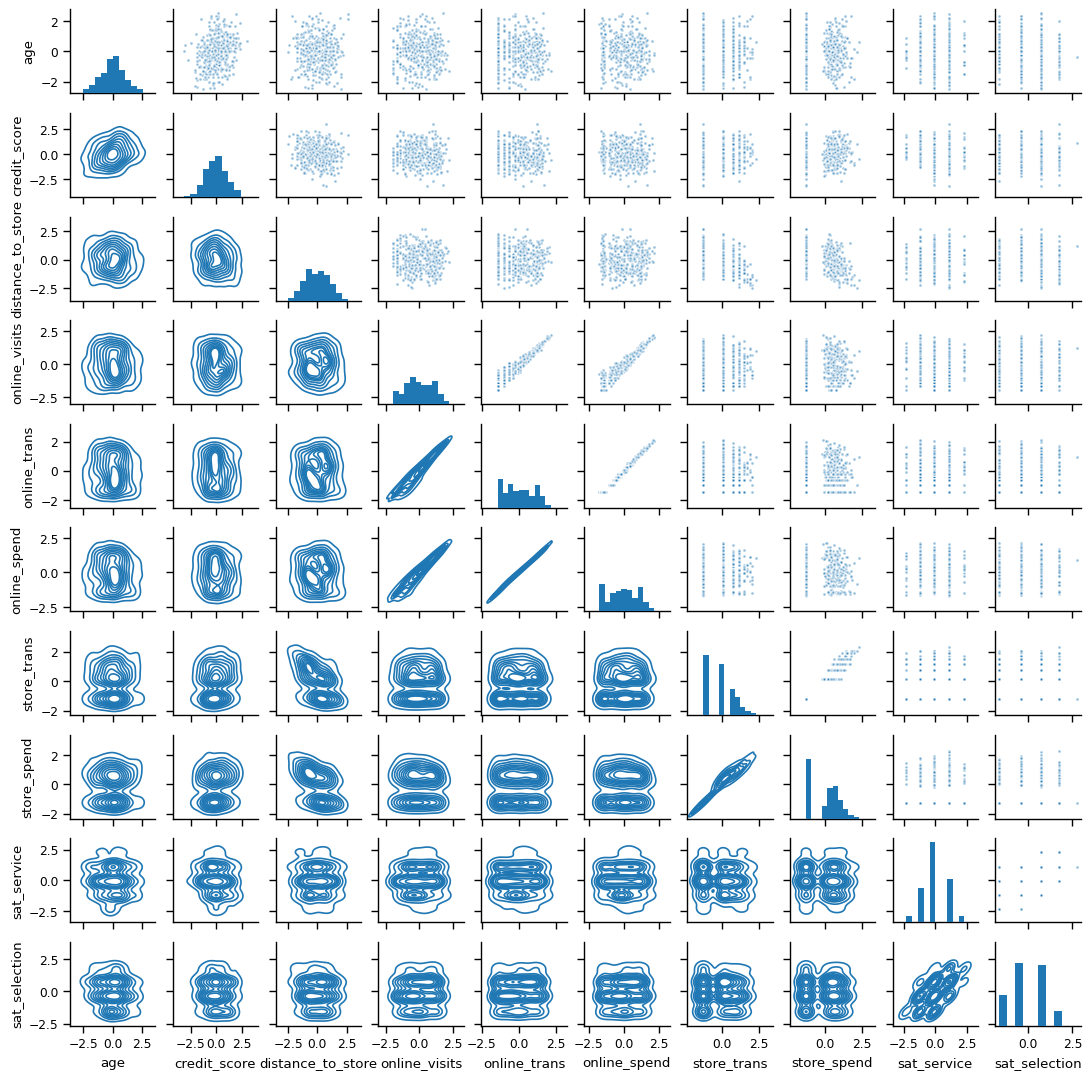

In [1]:
#Additional Linear Modeling Topics

#Handling highly correlated variables

#Initial Linear Model of Online Spend

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.stats import anova as sms_anova

#Load in the data 
cust_df = pd.read_csv('http://bit.ly/PMR-ch8pt1')
cust_df.head(5)
cust_df.describe(include = 'all').T

#Crete spend model
spend_m1 = smf.ols(('online_spend ~ age + credit_score + email'
                    '+ distance_to_store + online_visits'
                    '+ online_trans + store_trans + store_spend'
                    '+ sat_service + sat_selection'),
                    data = cust_df.loc[cust_df.online_spend > 0,
                                       'age':]).fit()
spend_m1.summary()

#Checking the data with pairgrid 
sns.set_context('paper')

g = sns.PairGrid(cust_df.loc[:,'age':].fillna(-1),height = 1.1)
g.map_upper(plt.scatter, linewidth = 1, edgecolor = 'w', s = 5, alpha = 0.5)
g.map_diag(plt.hist)
g.map_lower(sns.kdeplot)

#Data highly skewed/correlated, normalize and scale 
# Function to normalize data
import scipy.stats as ss
import sklearn.preprocessing as pp 

def autotransform(x):
    x_bc, lmbd = ss.boxcox(1 + x)
    return pp.scale(x_bc)

#Use the autotransform to make the data more standarized
idx_complete = (cust_df.isna().sum(axis = 1) == 0)
cust_df_bc = cust_df.loc[(idx_complete) & 
                         (cust_df.online_spend > 0), 'age':].copy()
col_idx = cust_df_bc.columns != 'email'
cust_df_bc.iloc[:,col_idx] = \
    cust_df_bc.iloc[:,col_idx].apply(autotransform)

#Looking at it with pairplot
g = sns.PairGrid(cust_df_bc, height = 1.1)
g.map_upper(plt.scatter, linewidth = 1, edgecolor = 'w', s = 5, alpha = 0.5)
g.map_diag(plt.hist)
g.map_lower(sns.kdeplot)

#refit the model using transformed data:
spend_m2 = smf.ols('online_spend ~ age + credit_score + email'
                   '+ distance_to_store + online_visits'
                   '+ online_trans + store_trans + store_spend'
                   '+ sat_service + sat_selection',
                   data =cust_df_bc).fit()
spend_m2.summary()

#Model didnt change much, look at only online spend,trans
spend_m3 = smf.ols('online_spend ~ online_trans',
                   data = cust_df_bc).fit()
spend_m3.summary()

from statsmodels.stats import anova as sms_anova

sms_anova.anova_lm(spend_m2,spend_m3)

In [21]:
#Remediating Collinearity 

#Using Variance Inflation Factor (VIF) for the first coefficient
from statsmodels.stats.outliers_influence import variance_inflation_factor

variance_inflation_factor(spend_m2.model.exog,1)

#Creating a VIF function to run through all 
def print_variance_inflation_factors(model):
    for i, param in enumerate(model.params.index):
        print('VIF: {:.3f}, Parameter: {}'.format(
            variance_inflation_factor(model.model.exog, i),param))
        
print_variance_inflation_factors(spend_m2)
print('-------------------------------------')

#Omitting highly correlated variables
spend_m4 = smf.ols('online_spend ~ age + credit_score + email'
             '+ distance_to_store + online_visits'
             '+ store_spend + sat_service + sat_selection',
             data = cust_df_bc).fit()
spend_m4.summary()

print_variance_inflation_factors(spend_m4)
print('-------------------------------------')

#Using PCA to deal with correlated data
from sklearn import decomposition

#create a combined online variable using PCA
online_pca = decomposition.PCA().fit_transform(cust_df_bc[['online_visits','online_trans']])
cust_df_bc['online'] = online_pca[:,0]

#create a combined store variable using PCA
store_pca = decomposition.PCA().fit_transform(cust_df_bc[['store_spend','store_trans']])
cust_df_bc['store'] = store_pca[:,0]

spend_m5 = smf.ols('online_spend ~ age + credit_score + email'
                   '+ distance_to_store + online + store'
                   '+ sat_service + sat_selection',
                   data = cust_df_bc).fit()
spend_m5.summary()

print_variance_inflation_factors(spend_m5)
print('-------------------------------------')


VIF: 6.504, Parameter: Intercept
VIF: 1.051, Parameter: email[T.yes]
VIF: 1.095, Parameter: age
VIF: 1.112, Parameter: credit_score
VIF: 1.375, Parameter: distance_to_store
VIF: 13.354, Parameter: online_visits
VIF: 13.413, Parameter: online_trans
VIF: 15.977, Parameter: store_trans
VIF: 15.254, Parameter: store_spend
VIF: 1.524, Parameter: sat_service
VIF: 1.519, Parameter: sat_selection
-------------------------------------
VIF: 6.450, Parameter: Intercept
VIF: 1.040, Parameter: email[T.yes]
VIF: 1.082, Parameter: age
VIF: 1.104, Parameter: credit_score
VIF: 1.299, Parameter: distance_to_store
VIF: 1.028, Parameter: online_visits
VIF: 1.313, Parameter: store_spend
VIF: 1.518, Parameter: sat_service
VIF: 1.518, Parameter: sat_selection
-------------------------------------
VIF: 6.474, Parameter: Intercept
VIF: 1.045, Parameter: email[T.yes]
VIF: 1.082, Parameter: age
VIF: 1.102, Parameter: credit_score
VIF: 1.337, Parameter: distance_to_store
VIF: 1.032, Parameter: online
VIF: 1.350, 

In [ ]:
#Basics of Logistic Regression Model
from scipy.special import expit
from scipy.special import logit

#Computing by hand with expit
np.exp(0) / (np.exp(0) + 1)
expit(0)
expit(-np.inf) #likelihood 0
expit(2) #moderate prob = 88% chance
expit(-0.2) #weak likelihood


#Looking at the logit model
np.log(0.88 / (1 - 0.88)) #moderate Likelihood
logit(0.88) #equivalent to hand computation

np.float64(1.9924301646902063)

In [ ]:
#Data for logistice Regression of Season Passes

pass_df = pd.read_csv('http://bit.ly/PMR-ch8pt2')
pass_df.Pass = pass_df.Pass.astype(
    pd.api.types.CategoricalDtype(categories = ['YesPass','NoPass'],
                                  ordered = True))
pass_df.Promo = pass_df.Promo.astype(
    pd.api.types.CategoricalDtype(categories = ['NoBundle', 'Bundle'],
                                  ordered = True))

pass_df.head()

pass_df.describe().T



,count,unique,top,freq
Channel,3156,3,Mail,1328
Promo,3156,2,Bundle,1674
Pass,3156,2,YesPass,1589


In [ ]:
#Fitting a Logistic Model